In [406]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.model_selection import GridSearchCV

## 1. Dat


In [407]:
X_train = pd.read_csv('../data/X_train.csv')
y_train = pd.read_csv('../data/y_train.csv')
X_test = pd.read_csv('../data/X_test.csv')
y_test = pd.read_csv('../data/y_test.csv')

In [408]:
n_samples, n_features = X_train.shape
print('Les données d\'entraînement contiennent : {} échantillons de dimension {}'.format(n_samples, n_features))
print('Les données de test contiennent : {} échantillons de dimension {}'.format(X_test.shape[0], X_test.shape[1]))

Les données d'entraînement contiennent : 1494 échantillons de dimension 35
Les données de test contiennent : 654 échantillons de dimension 35


### Description des données

In [409]:
with pd.option_context('display.max_columns', None):
    display(X_train.head())

,ID,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,DE_GAS,FR_GAS,DE_COAL,FR_COAL,DE_HYDRO,FR_HYDRO,DE_NUCLEAR,FR_NUCLEAR,DE_SOLAR,FR_SOLAR,DE_WINDPOW,FR_WINDPOW,DE_LIGNITE,DE_RESIDUAL_LOAD,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
0,1054,206,FR,0.210099,-0.427458,-0.606523,0.606523,NaN,0.692860,NaN,-0.692860,0.441238,-0.213766,0.740627,0.288782,2.209047,0.207838,0.709614,-0.190463,0.101766,1.248911,-0.573370,-0.269460,0.870344,0.626666,-0.444661,-0.172680,-0.556356,-0.790823,-0.283160,-1.069070,-0.063404,0.339041,0.124552,-0.002445
1,2049,501,FR,-0.022399,-1.003452,-0.022063,0.022063,-0.573520,-1.130838,0.573520,1.130838,0.174773,0.426940,-0.170392,-0.762153,0.187964,-0.807112,-1.882740,-2.185961,1.987428,3.237380,-0.035514,-0.107350,-0.194308,-0.395469,-1.183194,-1.240300,-0.770457,1.522331,0.828412,0.437419,1.831241,-0.659091,0.047114,-0.490365
2,1924,687,FR,1.395035,1.978665,1.021305,-1.021305,-0.622021,-1.682587,0.622021,1.682587,2.351913,2.122241,1.572267,0.777053,-0.108578,0.779142,-1.897109,0.735137,-1.115583,-0.371039,-0.298755,-0.141239,0.428272,1.336625,1.947273,-0.480700,-0.313338,0.431134,0.487608,0.684884,0.114836,0.535974,0.743338,0.204952
3,297,720,DE,-0.983324,-0.849198,-0.839586,0.839586,-0.270870,0.563230,0.270870,-0.563230,0.487818,0.194659,-1.473817,-0.786025,-0.368417,1.320483,-0.205547,-1.589554,1.751523,0.562944,-0.010090,0.366885,-2.330557,-1.191889,-0.976974,-1.114838,-0.507570,-0.499409,-0.236249,0.350938,-0.417514,0.911652,-0.296168,1.073948
4,1101,818,FR,0.143807,-0.617038,-0.924990,0.924990,NaN,0.990324,NaN,-0.990324,0.238693,-0.240862,1.003734,-0.274975,-0.230179,-0.795983,-0.005581,0.176935,0.693543,0.723587,-0.774941,-0.564498,0.691040,0.571613,-0.526267,-0.541465,-0.424550,-1.088158,-1.011560,0.614338,0.729495,0.245109,1.526606,2.614378


Les données d'entrée possèdent 35 colonnes :

- ID : Identifiant d'indexe unique, associé à un jour (DAY_ID) et un pays (COUNTRY),
- DAY_ID : Identifiant du jour - les dates ont été annonymisées en préservant la structure des données,
- COUNTRY : Identifiant du pays - DE = Allemagne, FR = France, 

et composées ensuite de variations journalières du prix de matières premières,

- GAS_RET : Gaz en Europe,
- COAL_RET : Charbon en Europe,
- CARBON_RET : Futures sur les emissions carbone, 

de mesures météorologiques (journalières, dans le pays x),

- x_TEMP : Temperature,
- x_RAIN : Pluie,
- x_WIND : Vent,

de mesures de productions d'energie (journalière, dans le pays x),

- x_GAS : Gaz naturel,
- x_COAL : Charbon,
- x_HYDRO : Hydrolique,
- x_NUCLEAR : Nucléaire,
- x_SOLAR : Photovoltaïque,
- x_WINDPOW : Eolienne,
- x_LIGNITE : Lignite,

et de mesures d'utilisation électrique (journalières, dans le pays x),

- x_CONSUMPTON : Electricité totale consommée,
- x_RESIDUAL_LOAD : Electricité consommée après utilisation des énergies renouvelables,
- x_NET_IMPORT: Electricité importée depuis l'Europe,
- x_NET_EXPORT: Electricité exportée vers l'Europe,
- DE_FR_EXCHANGE: Electricité échangée entre Allemagne et France,
- FR_DE_EXCHANGE: Electricité échangée entre France et Allemagne.



#### Commentaires:
- Dans le benchmarck FR et DE sont traités de la même facon. Vaut-il mieux les traiter séparamment.
- Si nous construisons deux modèles distincts, alors le dataset perdra considérablement en terme de qualité. En effet nous diviserons presque par deux le nombre d'observations pour chaque modèle
- Il faudrait donc améliorer le jeu de données pour pouvoir construire un unique modèle de prédiction qualitatif.

In [410]:
X_train["DAY_ID"].value_counts().head(1000)


DAY_ID
77      2
237     2
231     2
1001    2
1070    2
       ..
0       1
308     1
721     1
969     1
90      1
Name: count, Length: 851, dtype: int64

In [411]:
day_ids = [77, 237, 231, 1001, 1070, 1112, 908, 757, 542, 391]

X_train[X_train["DAY_ID"].isin(day_ids)].sort_values("DAY_ID")


,ID,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,...,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
492,1278,77,FR,0.204839,-0.556874,-0.868887,0.868887,-0.923998,0.858085,0.923998,...,-0.606544,-1.316356,-0.173395,-0.419634,-0.195610,-1.597233,-0.701258,-1.394954,-0.403791,-0.316186
852,62,77,DE,0.204839,-0.556874,-0.868887,0.868887,-0.923998,0.858085,0.923998,...,-0.606544,-1.316356,-0.173395,-0.419634,-0.195610,-1.597233,-0.701258,-1.394954,-0.403791,-0.316186
550,2060,231,FR,-0.511138,-0.802438,0.938683,-0.938683,-0.723702,-2.174215,0.723702,...,-0.779227,-1.516457,-0.478945,0.909630,0.100861,0.171330,0.453644,-0.664758,-0.189012,-0.667172
1212,844,231,DE,-0.511138,-0.802438,0.938683,-0.938683,-0.723702,-2.174215,0.723702,...,-0.779227,-1.516457,-0.478945,0.909630,0.100861,0.171330,0.453644,-0.664758,-0.189012,-0.667172
561,1363,237,FR,0.664205,0.326647,-0.213652,0.213652,-0.027239,-0.462336,0.027239,...,0.349165,0.045906,-0.739773,-0.849181,-0.669926,-0.193674,-0.369820,0.444776,-0.193880,0.318229
567,147,237,DE,0.664205,0.326647,-0.213652,0.213652,-0.027239,-0.462336,0.027239,...,0.349165,0.045906,-0.739773,-0.849181,-0.669926,-0.193674,-0.369820,0.444776,-0.193880,0.318229
560,2050,391,FR,-0.305770,-0.818128,0.397849,-0.397849,-0.299681,-1.494674,0.299681,...,-0.997108,-0.450657,-0.108242,1.390915,1.370472,-0.380167,0.859136,-1.033335,0.604034,-1.409869
1364,834,391,DE,-0.305770,-0.818128,0.397849,-0.397849,-0.299681,-1.494674,0.299681,...,-0.997108,-0.450657,-0.108242,1.390915,1.370472,-0.380167,0.859136,-1.033335,0.604034,-1.409869
559,646,542,DE,1.166555,-0.318736,-0.243236,0.243236,0.976377,0.877926,-0.976377,...,-1.091336,-0.420718,-0.471684,2.543151,3.499060,1.297569,1.306755,-0.371456,2.309202,0.717430
960,1862,542,FR,1.166555,-0.318736,-0.243236,0.243236,0.976377,0.877926,-0.976377,...,-1.091336,-0.420718,-0.471684,2.543151,3.499060,1.297569,1.306755,-0.371456,2.309202,0.717430


In [412]:
y_train.loc[[1278, 62]]

,ID,TARGET
1278,878,-0.444789
62,1560,-0.532471


#### Commentaires 
- On observe que les features de certaines dates sont utilisés deux fois dans le dataset : une fois pour décrire la Variation du prix de l'électricté en France, et l'autre fois pour décrire celle en Allemagne
- On observe aussi que les même feautures  ont des impacts totalement différents sur la variation du prix de l'éléctricité en Allemagne ou en France. Il serait donc judicieux de bien préparer le set de données avant de passer à la modélisation.
- Une solution serait d'introduire des variable binaires DE et FR prenant des valeurs {0,1}.

Nous allons procéder à pré-traitement du dataset

In [413]:
# Sauvegarder la séparation entre train et test
ids_train = list(X_train["ID"])
ids_test = list(X_test["ID"])

X = pd.concat([X_train, X_test], ignore_index=True)
y = pd.concat([y_train, y_test], ignore_index=True)

### Les valeurs manquantes
- Pour les données numériques, nous souhaitons remplacer les données manquantes avec la méthode ffil. Cette méthode nécessite d'uiliser des séries temporelles, il faut donc trier les données par ordre chronologique. POur cela nous allons séparer le dataset en deux : les variations allemandes et françaises, puis au sein de ces deux datasets nous trirons les données dans le l'ordre chronologique, puis nous appliquerons la méthode "ffill".
- Pour les données catégorielles, nous ajouterons une catégorie "données manquantes". 
- De plus pour la colonne "COUNTRY" nous allons utiliser un OneHot encoder pour créer les features binaires "DE" et "FR" 


In [414]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

In [415]:
# On vérifie qu'on a aucun DAY_ID manquant
X["DAY_ID"].isna().sum()

np.int64(0)

In [416]:
numeric_features = ['GAS_RET',
                     'COAL_RET', 
                     'CARBON_RET',
                     'DE_TEMP',
                     'DE_RAIN',
                     'DE_WIND',
                     'DE_GAS',
                     'DE_COAL',
                     'DE_HYDRO',
                     'DE_NUCLEAR',
                     'DE_SOLAR',
                     'DE_WINDPOW',
                     'DE_LIGNITE',
                     'DE_CONSUMPTION',
                     'DE_RESIDUAL_LOAD',
                     'DE_NET_IMPORT',
                     'DE_NET_EXPORT',
                     'FR_TEMP',
                     'FR_RAIN',
                     'FR_WIND',
                     'FR_GAS',
                     'FR_COAL',
                     'FR_HYDRO',
                     'FR_NUCLEAR',
                     'FR_SOLAR',
                     'FR_WINDPOW',
                     'FR_CONSUMPTION',
                     'FR_RESIDUAL_LOAD',
                     'FR_NET_IMPORT',
                     'FR_NET_EXPORT',
                     'DE_FR_EXCHANGE',
                     'FR_DE_EXCHANGE']
categorical_features = ['COUNTRY']

In [417]:
X_DE = X[X['COUNTRY'] == 'DE']
X_FR = X[X['COUNTRY'] == 'FR']

print(f"Le dataset allemand comporte {len(X_DE)} échantillons.")
print(f"Le dataset français comporte {len(X_FR)} échantillons.")

Le dataset allemand comporte 932 échantillons.
Le dataset français comporte 1216 échantillons.


In [418]:
# trier les datasets par ordre chronologique (DAY_ID)
X_DE = X_DE.sort_values("DAY_ID")
X_FR = X_FR.sort_values("DAY_ID")

# POur les features numériques : Appliquer forward fill, et 0 si première valeur
X_DE[numeric_features] = X_DE[numeric_features].fillna(method='ffill').fillna(0)
X_FR[numeric_features] = X_FR[numeric_features].fillna(method='ffill').fillna(0)

X_train = pd.concat([X_DE, X_FR])

# Pour les features catégorielles
categorical_transformer = Pipeline(steps=[
                                    ("imputer", SimpleImputer(strategy="constant", fill_value="Not defined")),
                                    ("onehot", OneHotEncoder(handle_unknown='ignore'))])

preproc = ColumnTransformer(transformers=[("cat", categorical_transformer, categorical_features)],
                           remainder='passthrough')  # passthrough pour garder les features numériques déjà traités intacts

# Appliquer la transformation
X_transformed = preproc.fit_transform(X_train)
# nouveau nom des colonnes après one-hot encoding
onehot_columns = ['COUNTRY_DE', 'COUNTRY_FR']
# garder le nom des colonnes numériques intactes
passthrough_columns = [col for col in X_train.columns if col not in categorical_features]
X = pd.DataFrame(X_transformed, columns=onehot_columns + passthrough_columns)


/var/folders/nq/qwtx6rd54k7686m_s4y2mxpw0000gn/T/ipykernel_29851/3207770397.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_DE[numeric_features] = X_DE[numeric_features].fillna(method='ffill').fillna(0)
/var/folders/nq/qwtx6rd54k7686m_s4y2mxpw0000gn/T/ipykernel_29851/3207770397.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_FR[numeric_features] = X_FR[numeric_features].fillna(method='ffill').fillna(0)


In [419]:
X.head()

,COUNTRY_DE,COUNTRY_FR,ID,DAY_ID,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,...,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
0,1.0,0.0,111.0,2.0,-0.068972,-0.667390,-1.102015,1.102015,-1.080403,0.256736,...,-0.540642,-0.344600,-0.372156,-0.623041,-0.926064,-0.148950,0.641235,1.802550,1.140920,0.900434
1,1.0,0.0,800.0,3.0,-0.134670,-0.834564,-1.051716,1.051716,-1.881881,-0.612133,...,-0.856321,-1.394561,-1.118297,0.244859,0.488650,-1.710888,-0.951057,0.440121,-0.064550,-0.032756
2,1.0,0.0,410.0,4.0,0.944117,0.203547,0.372743,-0.372743,0.656335,0.519380,...,-0.052684,-0.900802,-0.359430,-0.614570,-0.734964,1.192221,0.701597,-0.357747,0.696316,-0.426880
3,1.0,0.0,831.0,5.0,-0.297850,-0.470371,0.144615,-0.144615,-1.208286,-1.811403,...,-0.552878,-1.374757,-0.790071,0.333817,0.021868,-0.062187,1.459745,-0.117977,0.550433,0.781870
4,1.0,0.0,562.0,6.0,0.120788,-0.744840,-1.195940,1.195940,-1.670709,1.164429,...,-0.682853,3.127472,0.149032,0.324280,1.119383,-0.288148,-0.894852,2.213681,0.352223,0.518026


In [420]:
#print((X_train["DAY_ID"].value_counts() == 2).sum())


donc presque l'ensemble du data set. 

In [421]:
#with pd.option_context('display.max_columns', None):
    #display(X_train.isna().sum())


LA varibale X_net_import et X_net_export sont les memes variables, c'est le flux du pays. Donc attention a n'en utiliser que une seule sinon on a une colinearite parfaite. je propose qu'on cree une seule variable qu'on va utiliser. 
si la valeur est positive importation net, si la variable est negative exportation net 

In [422]:
#X_train["FR_net_elec_flow"] = X_train["x_NET_IMPORT"]

### La multicolinéarité

In [423]:
import seaborn as sns

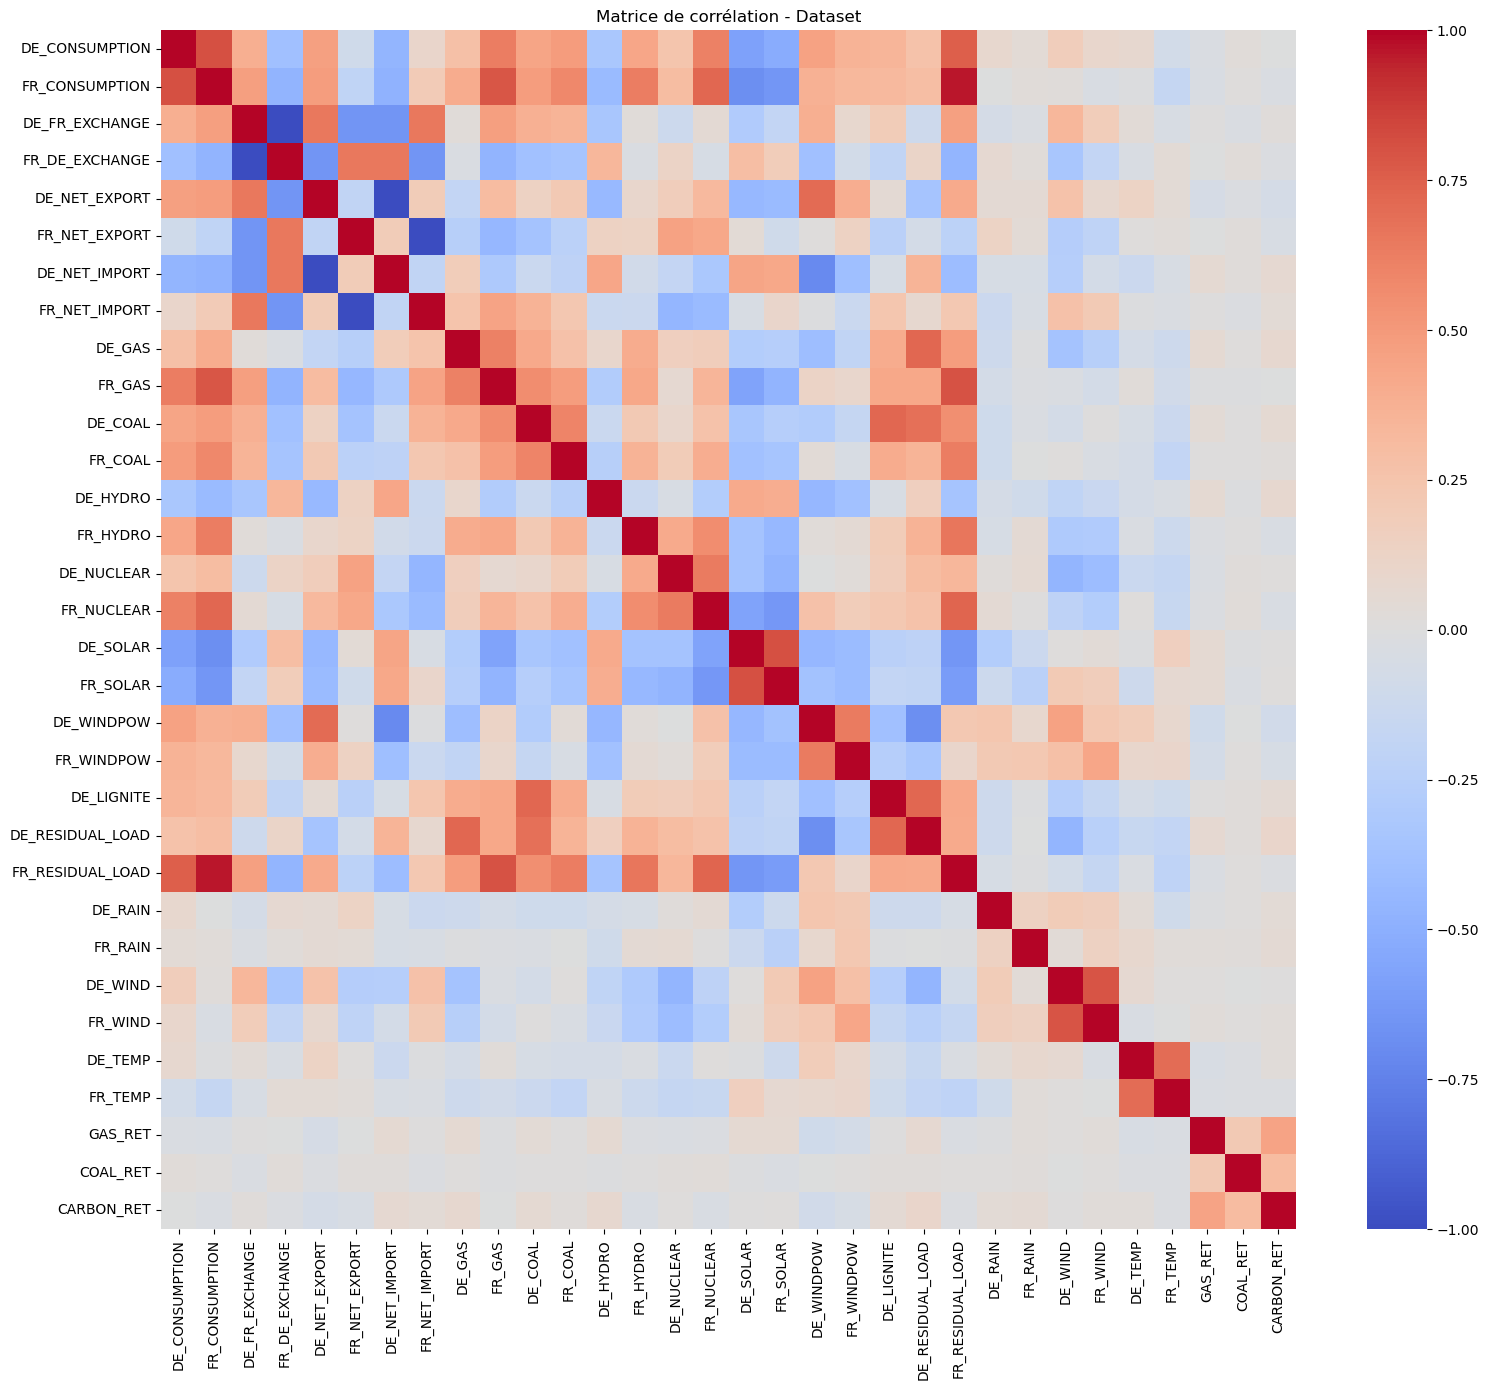

In [424]:
plt.figure(figsize=(16, 14))
numeric_cols = X.drop(columns=categorical_features + ['ID', 'DAY_ID', 'COUNTRY_DE', 'COUNTRY_FR'], errors='ignore')
sns.heatmap(numeric_cols.corr(), cmap="coolwarm", annot=False, fmt='.2f', cbar=True)
plt.title('Matrice de corrélation - Dataset')
plt.tight_layout()
plt.show()

In [425]:
# Trouver les colonnes à supprimer pour éviter la multicolinéarité
corr_matrix = numeric_cols.corr()
cols = corr_matrix.columns
cols_corr = []

for i in range(len(cols)):
    for j in range(i + 1, len(cols)):
        if abs(corr_matrix.iloc[i, j]) > 0.80:
            cols_corr.append((cols[i], cols[j]))

# Supprimer les doublons dans la liste
cols_corr = list(set(cols_corr))

print(f"Les features fortement corrélés sont (corrélation > 0.80):" )
print(cols_corr)

Les features fortement corrélés sont (corrélation > 0.80):
[('DE_CONSUMPTION', 'FR_CONSUMPTION'), ('DE_SOLAR', 'FR_SOLAR'), ('FR_GAS', 'FR_RESIDUAL_LOAD'), ('FR_CONSUMPTION', 'FR_RESIDUAL_LOAD'), ('DE_NET_EXPORT', 'DE_NET_IMPORT'), ('DE_FR_EXCHANGE', 'FR_DE_EXCHANGE'), ('FR_NET_EXPORT', 'FR_NET_IMPORT')]


#### Commentaires : 
- certains feautures sont extrêment corrélés, nous allons donc en supprimer de notre dataset pour éviter la multicolinéarité: "FR_RESIDUAL_LOAD", "DE_SOLAR", "DE_CONSUMPTION", "DE_WIND", "DE_NET_EXPORT", "DE_FR_EXCHANGE", "FR_NET_EXPORT".
-   nous décidons de supprimer les données méthéorologiques allamandes et non françaises, puisque la majorité de nos target values concerent les variations de prix française, nous pensons donc que les données météorologiques françaises seront donc plus significatives en moyennes.
- nous décidons de supprimer la quantité d'exportations et non d'emportations puis la France importe plus que ce qu'elle exporte.

In [426]:
cols_to_remove = ["FR_RESIDUAL_LOAD", "DE_SOLAR", "DE_CONSUMPTION", "DE_WIND", "DE_NET_EXPORT", "DE_FR_EXCHANGE", "FR_NET_EXPORT"]
X = X.drop(cols_to_remove, axis=1)

### Valeurs extrêmes

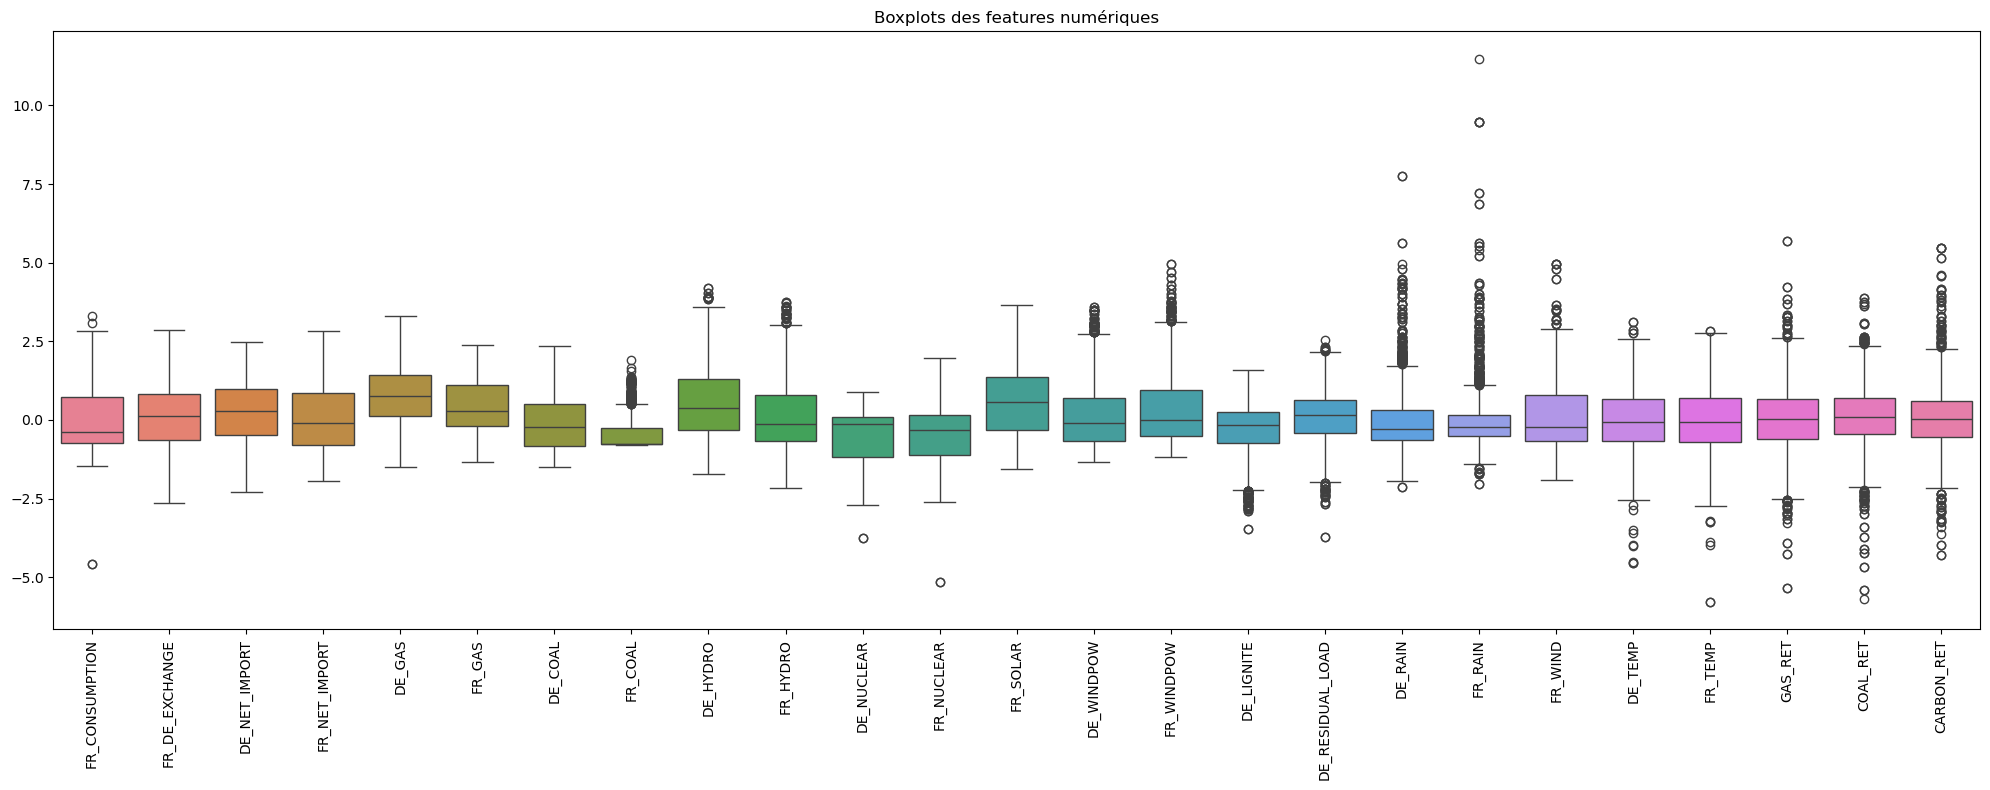

In [427]:
# Boxplot de toutes les features numériques sur un seul graphique
numeric_cols = X.drop(columns=categorical_features + ['ID', 'DAY_ID', 'COUNTRY_DE', 'COUNTRY_FR'], errors='ignore')

plt.figure(figsize=(20, 8))
sns.boxplot(data=numeric_cols)
plt.xticks(rotation=90)
plt.title('Boxplots des features numériques')
plt.tight_layout()
plt.show()


In [428]:
# Supprimer les valeurs extrêmes avec la méthode Z-score
numeric_cols_names = X.drop(columns=categorical_features + ['ID', 'DAY_ID', 'COUNTRY_DE', 'COUNTRY_FR'], errors='ignore').columns
z_scores = np.abs((X[numeric_cols_names] - X[numeric_cols_names].mean()) / X[numeric_cols_names].std())
outlier_threshold = 3
X = X[(z_scores <= outlier_threshold).all(axis=1)]

print(f"Nombre d'échantillons après suppression des outliers : {len(X)}")

y = y[y["ID"].isin(X["ID"])]

Nombre d'échantillons après suppression des outliers : 1908


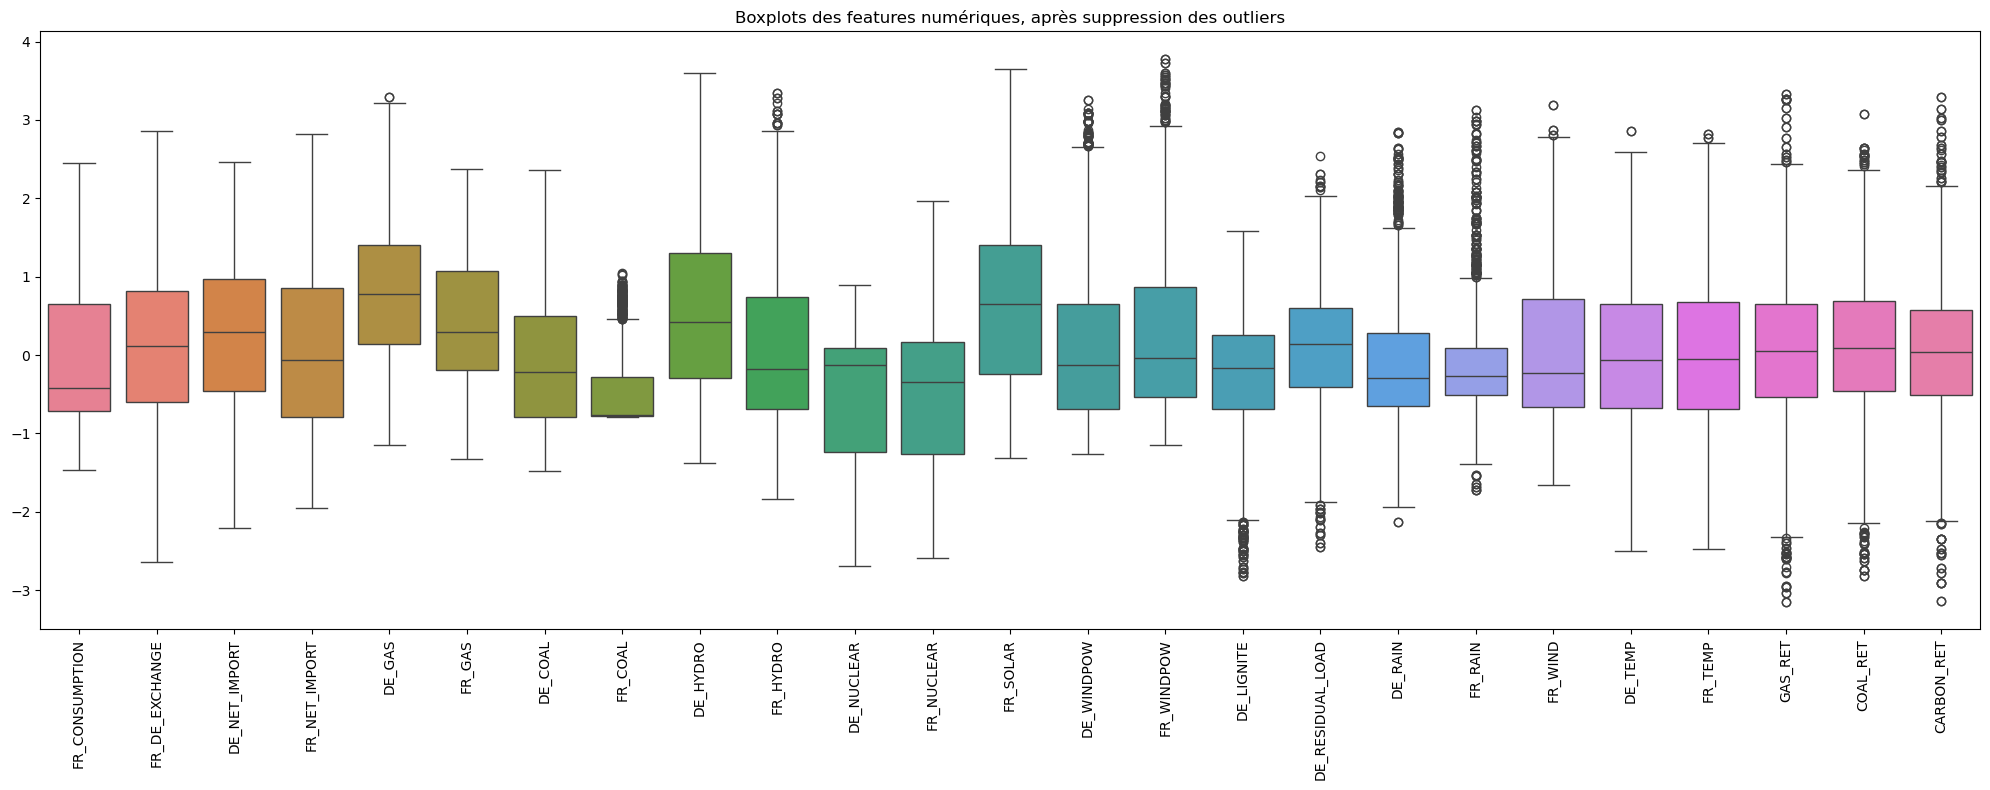

In [429]:
numeric_cols = X.drop(columns=categorical_features + ['ID', 'DAY_ID', 'COUNTRY_DE', 'COUNTRY_FR'], errors='ignore')

plt.figure(figsize=(20, 8))
sns.boxplot(data=numeric_cols)
plt.xticks(rotation=90)
plt.title('Boxplots des features numériques, après suppression des outliers')
plt.tight_layout()
plt.show()


### Scaling des données numériques

In [430]:
# Appliquer StandardScaler pour normaliser les données numériques
scaler = StandardScaler()
numeric_cols = X.drop(columns=['ID', 'DAY_ID', 'COUNTRY_DE', 'COUNTRY_FR'], errors='ignore').columns
X_scaled = scaler.fit_transform(X[numeric_cols])

X[numeric_cols] = X_scaled


### Correlation between Taget and Features

/opt/homebrew/anaconda3/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/homebrew/anaconda3/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/opt/homebrew/anaconda3/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/homebrew/anaconda3/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


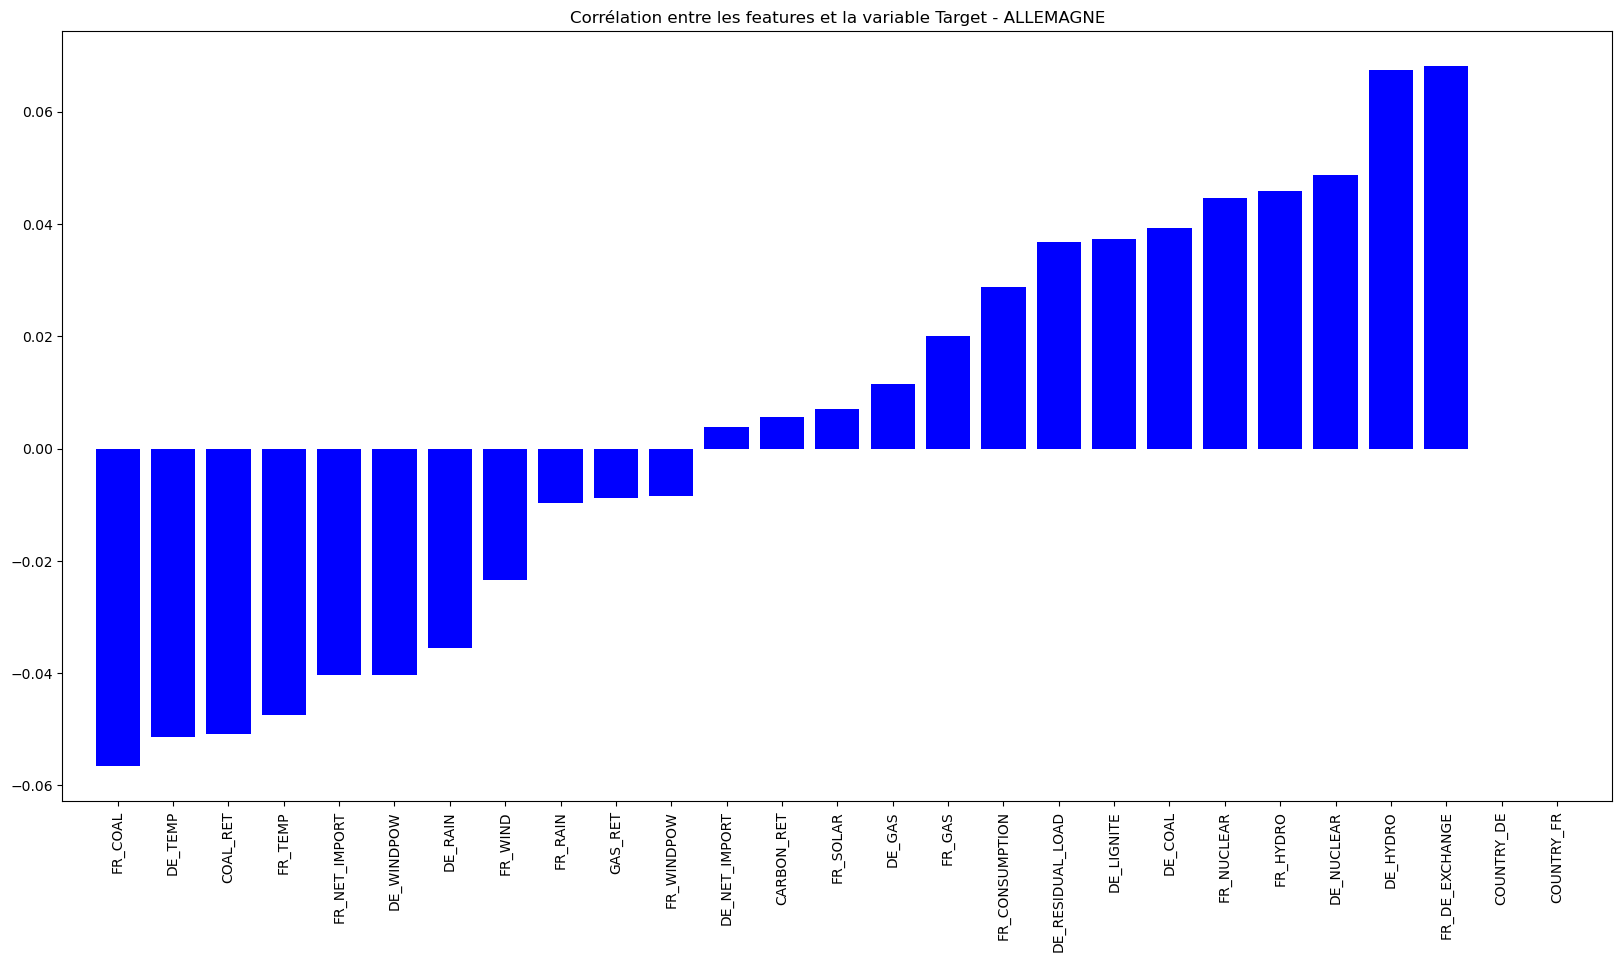

Variables avec |corrélation| > 0.045 (DE):
FR_COAL          -0.056581
DE_TEMP          -0.051332
COAL_RET         -0.050893
FR_TEMP          -0.047434
FR_HYDRO          0.045905
DE_NUCLEAR        0.048780
DE_HYDRO          0.067537
FR_DE_EXCHANGE    0.068135
dtype: float64


In [431]:
# Corrélations pour l'Allemagne (DE)
X_DE_filtered = X[X['COUNTRY_DE'] == 1]
y_DE_filtered = y[y['ID'].isin(X_DE_filtered['ID'])]

corr_matrix_DE = X_DE_filtered.drop(columns=['ID', 'DAY_ID']).corrwith(y_DE_filtered['TARGET'], method='pearson')
corr_matrix_DE = corr_matrix_DE.sort_values()

plt.figure(figsize=(20, 10))
plt.title("Corrélation entre les features et la variable Target - ALLEMAGNE")
plt.bar(range(len(corr_matrix_DE)), corr_matrix_DE, color="blue", align="center")
plt.xticks(range(len(corr_matrix_DE)), corr_matrix_DE.index, rotation='vertical')
plt.xlim([-1, len(corr_matrix_DE)])
plt.show()

print("Variables avec |corrélation| > 0.045 (DE):")
print(corr_matrix_DE[abs(corr_matrix_DE) > 0.045])

#### Commentaires:

- Les variables les plus corrélées avec les variations du prix de l'electricité allemandes sont : FR_COAL, DE_TEMP, COAL_RET, FR_TEMP, FR_HYDRO, DE_NUCLEAR, DE_HYDRO, FR_DE_EXCHANGE

/opt/homebrew/anaconda3/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/homebrew/anaconda3/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/opt/homebrew/anaconda3/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/homebrew/anaconda3/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


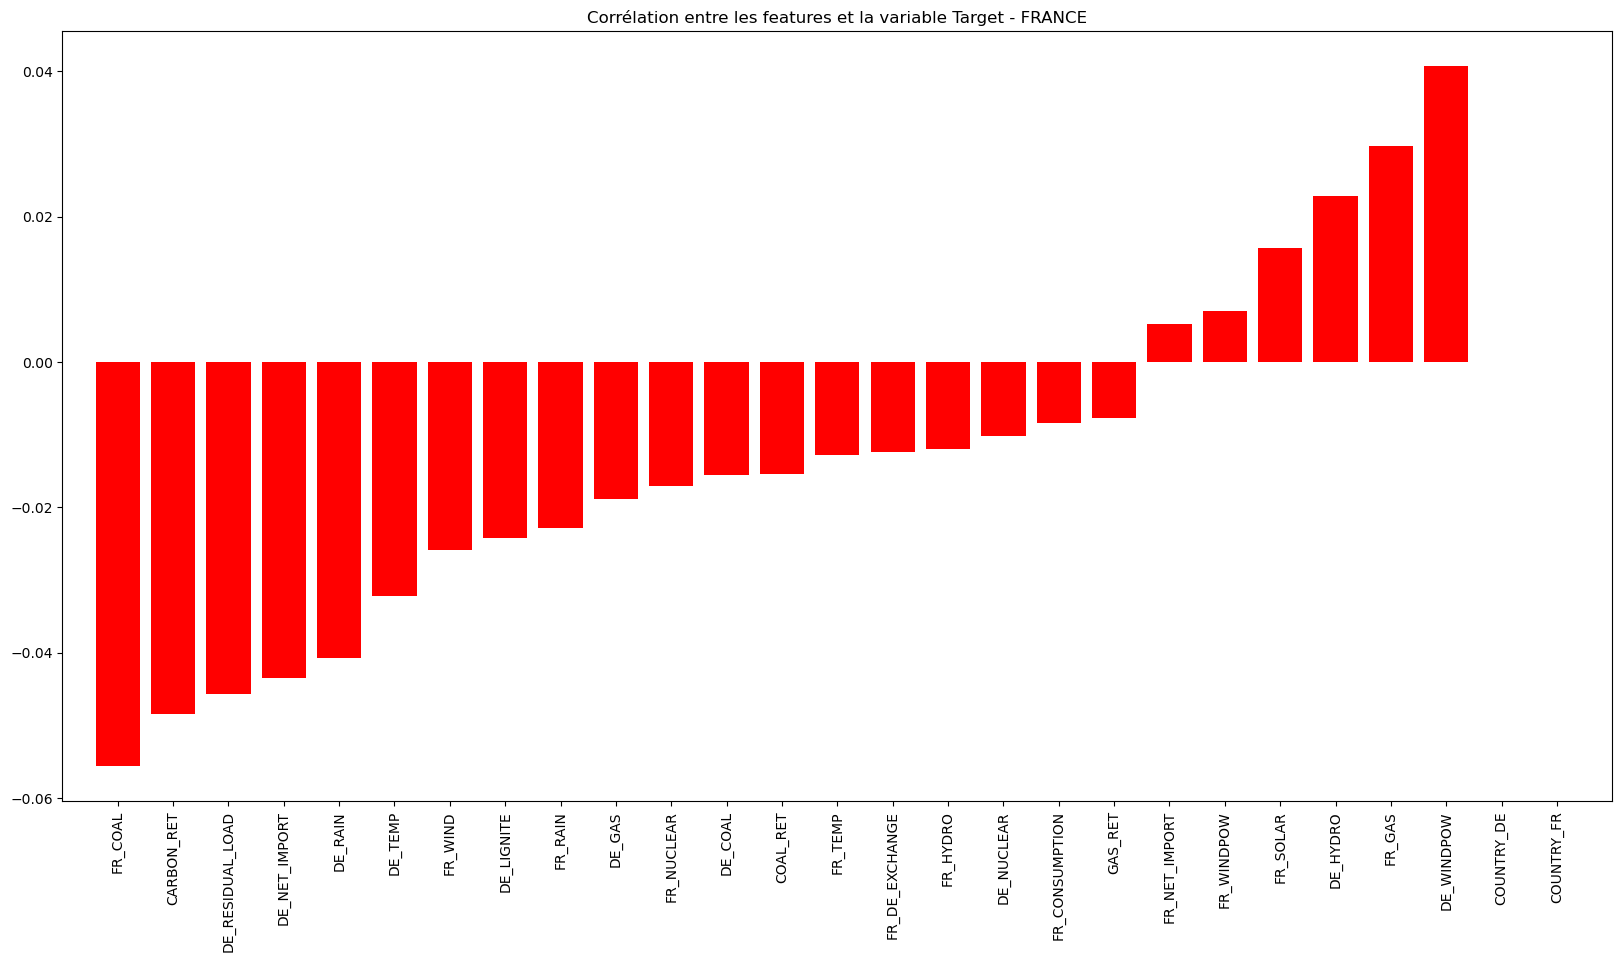

Variables avec |corrélation| > 0.045 (FR):
FR_COAL            -0.055601
CARBON_RET         -0.048470
DE_RESIDUAL_LOAD   -0.045674
dtype: float64


In [432]:
# Corrélations pour la France (FR)
X_FR_filtered = X[X['COUNTRY_FR'] == 1]
y_FR_filtered = y[y['ID'].isin(X_FR_filtered['ID'])]

corr_matrix_FR = X_FR_filtered.drop(columns=['ID', 'DAY_ID']).corrwith(y_FR_filtered['TARGET'], method='pearson')
corr_matrix_FR = corr_matrix_FR.sort_values()

plt.figure(figsize=(20, 10))
plt.title("Corrélation entre les features et la variable Target - FRANCE")
plt.bar(range(len(corr_matrix_FR)), corr_matrix_FR, color="red", align="center")
plt.xticks(range(len(corr_matrix_FR)), corr_matrix_FR.index, rotation='vertical')
plt.xlim([-1, len(corr_matrix_FR)])
plt.show()

print("Variables avec |corrélation| > 0.045 (FR):")
print(corr_matrix_FR[abs(corr_matrix_FR) > 0.045])

#### Commentaires:

- Les variables les plus corrélées avec les variations du prix de l'electricité allemandes sont : FR_COAL, CARBON_RET, DE_RESIDUAL_LOAD

Nous pouvons à présent redéfinir les jeux de données d'entrainement et de test. Penser à vérifier les dimensions de X et y

In [433]:
# Redéfinir les jeux de données d'entrainement et de test
# Important : utiliser les index de X pour filtrer y également
X_train = X[X['ID'].isin(ids_train)].copy()
X_test = X[X['ID'].isin(ids_test)].copy()

y_train = y[y['ID'].isin(ids_train)].copy()
y_test = y[y['ID'].isin(ids_test)].copy()

# Créer y aligné avec X (après suppression des outliers)

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")


X_train: (1332, 29), y_train: (1332, 2)
X_test: (576, 29), y_test: (576, 2)


## 2. Modèle - Regression (Lasso, Ridge and Elastic Net)

In [434]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

In [435]:
lasso = Lasso(max_iter=5000, random_state=42)

parameters = {
    'alpha': [0.01, 0.1, 1, 10, 100]
}

predictor_1 = GridSearchCV(
    estimator=lasso,
    param_grid=parameters,
    cv=3,
    scoring='r2',
    n_jobs=-1
)

# Extraire uniquement la colonne TARGET de y_train et y_test
predictor_1.fit(X_train, y_train['TARGET'].values.ravel())

print(f"Meilleur hyperparamètre : {predictor_1.best_params_}")
print(f"Meilleur score R² en train (CV) : {predictor_1.best_score_:.4f}")
print(f"Score R² sur test : {predictor_1.score(X_test, y_test['TARGET'].values.ravel()):.4f}")


Meilleur hyperparamètre : {'alpha': 100}
Meilleur score R² en train (CV) : -0.0025
Score R² sur test : -0.0234


## 3. Modèle - Réseau de Neurone

## 4. Modèle - XGBoost